In [1]:
!pip install pyparsing==2.4.6

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import sys
sys.path.append("../utils/") 
from utilities import performance_metrics
import time

from src.core import Term, Atom
from src.ilp import Language_Frame, Program_Template, Rule_Template
from src.dilp import DILP
import tensorflow as tf
import numpy as np
from src.utils import process_file, process_dir, output_rules, test_rule, create_table
from src.generate_template import create_templates
import duckdb
tf.random.set_seed(1000)
np.random.seed(1000)

2024-05-16 15:37:04.777693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 15:37:05.680616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
con = duckdb.connect(':memory:')
# enable automatic query parallelization
con.execute("PRAGMA threads=2")
# enable caching of parquet metadata
con.execute("PRAGMA enable_object_cache")

In [4]:
def train(dilp):
    start_time = time.time()
    dilp.train()
    finish_time = time.time()
    print("execution time %d" % (finish_time - start_time))
def test(dilp):
    rules = dilp.show_definition()
    sql_str = output_rules(rules)
    predicted_table = test_rule(con, sql_str, target_predicate="Target")
    performance_metrics(predicted_table["Target"], input_table["Target"], labels=[True,False])
    return sql_str

## Rule template
 Rule_Template(v: int, allow_intensional: bool): 
v is number of existentially qualified variables(X,Y,Z...) in the clause

Program_Template(p_a: list, rules: dict, T: int):
 p_a {list} -- set of auxiliary predicates; these are the additional invented predicates used to help define the target predicate
 
 
 rules {tuple} -- Map of intensional predicate to a pair if rule templates 
 T {int} -- Max number of steps of forward chaining inference

In [5]:
# p_a = [Atom([term_x_0], 'pred')]
# target_rule = (Rule_Template(v=0, allow_intensional=True), None)
# p_a_rule_1 = (Rule_Template(v=0, allow_intensional=False), None)

# rules = {p_a[0]: p_a_rule_1, target: target_rule} 

## a, b learning

In [6]:
%%time 
input_dir = '../examples/a-b/'
input_table = create_table(con, input_dir)
target, p_e, constants, B, P, N = process_dir(input_dir)

# arity 1
term_x_0 = Term(True, 'X_0')
p_a, rules = create_templates(p_e, target, term_x_0)

# target_rule = (Rule_Template(v=0, allow_intensional=False), None)
# rules = {target: target_rule} 

language_frame = Language_Frame(target, p_e, constants)


96
end of facts processing
22
end of positive examples processing
52
end negative examples processing
data is in order
CPU times: user 46.1 ms, sys: 6.73 ms, total: 52.8 ms
Wall time: 51.2 ms


In [7]:
program_template = Program_Template(p_a, rules, T=2)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
dilp.show_definition()


----------------------------
Target(X_0)
Target(X_0) -> B(X_0),B(X_0)
None
----------------------------


[(Target(X_0) -> B(X_0),B(X_0), None)]

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 0.5646758079528809
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(83) Expected: 0 0.334
Target(80) Expected: 1 1.000
Target(0) Expected: 0 0.718
Target(3) Expected: 0 0.334
Target(49) Expected: 1 1.000
Target(72) Expected: 0 0.718
Target(19) Expected: 0 0.334
Target(36) Expected: 1 1.000
Target(2) Expected: 1 1.000
Target(67) Expected: 1 1.000
Target(76) Expected: 0 0.334
Target(21) Expected: 0 0.334
Target(84) Expected: 0 0.334
Target(42) Expected: 1 1.000
Target(92) Expected: 0 0.718
Target(59) Expected: 0 0.334
Target(61) Expected: 0 0.334
Target(34) Expected: 1 1.000
Target(68) Expected: 1 1.000
Target(71) Expected: 0 0.718
Target(98) 

'select A and B as Target,\n'

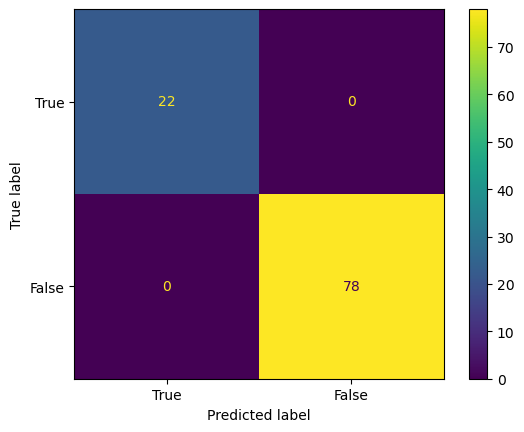

In [8]:
train(dilp)
test(dilp)

In [9]:
input_table['Target'].sum()/len(input_table)

0.22

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 0.41711661219596863
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(83) Expected: 0 0.466
Target(80) Expected: 1 1.000
Target(0) Expected: 0 0.425
Target(3) Expected: 0 0.466
Target(49) Expected: 1 1.000
Target(72) Expected: 0 0.425
Target(19) Expected: 0 0.466
Target(36) Expected: 1 1.000
Target(2) Expected: 1 1.000
Target(67) Expected: 1 1.000
Target(76) Expected: 0 0.466
Target(21) Expected: 0 0.466
Target(84) Expected: 0 0.466
Target(42) Expected: 1 1.000
Target(92) Expected: 0 0.425
Target(59) Expected: 0 0.466
Target(61) Expected: 0 0.466
Target(34) Expected: 1 1.000
Target(68) Expected: 1 1.000
Target(71) Expected: 0 0.425
Target(98)

'select A and B as Target,\n'

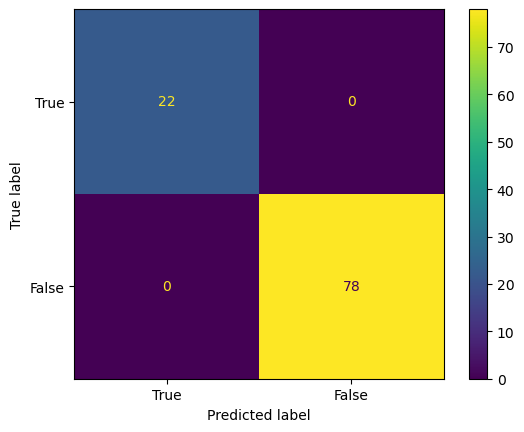

In [10]:
program_template = Program_Template(p_a, rules, T=3)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 1.1269886493682861
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(83) Expected: 0 0.724
Target(80) Expected: 1 1.000
Target(0) Expected: 0 0.861
Target(3) Expected: 0 0.724
Target(49) Expected: 1 1.000
Target(72) Expected: 0 0.861
Target(19) Expected: 0 0.724
Target(36) Expected: 1 1.000
Target(2) Expected: 1 1.000
Target(67) Expected: 1 1.000
Target(76) Expected: 0 0.724
Target(21) Expected: 0 0.724
Target(84) Expected: 0 0.724
Target(42) Expected: 1 1.000
Target(92) Expected: 0 0.861
Target(59) Expected: 0 0.724
Target(61) Expected: 0 0.724
Target(34) Expected: 1 1.000
Target(68) Expected: 1 1.000
Target(71) Expected: 0 0.861
Target(98) 

'select A and B as Target,\n'

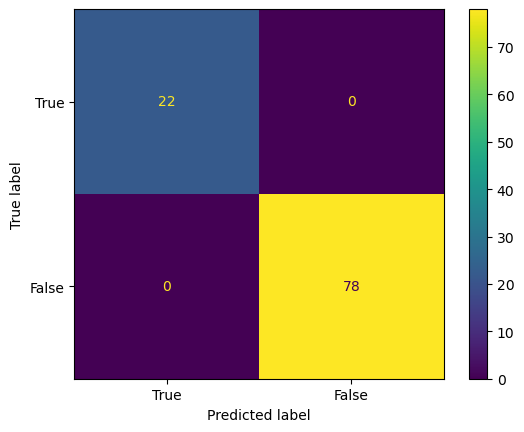

In [11]:
program_template = Program_Template(p_a, rules, T=5)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp)


Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 1.326913833618164
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(83) Expected: 0 0.871
Target(80) Expected: 1 1.000
Target(0) Expected: 0 0.818
Target(3) Expected: 0 0.871
Target(49) Expected: 1 1.000
Target(72) Expected: 0 0.818
Target(19) Expected: 0 0.871
Target(36) Expected: 1 1.000
Target(2) Expected: 1 1.000
Target(67) Expected: 1 1.000
Target(76) Expected: 0 0.871
Target(21) Expected: 0 0.871
Target(84) Expected: 0 0.871
Target(42) Expected: 1 1.000
Target(92) Expected: 0 0.818
Target(59) Expected: 0 0.871
Target(61) Expected: 0 0.871
Target(34) Expected: 1 1.000
Target(68) Expected: 1 1.000
Target(71) Expected: 0 0.818
Target(98) E

'select A and B as Target,\n'

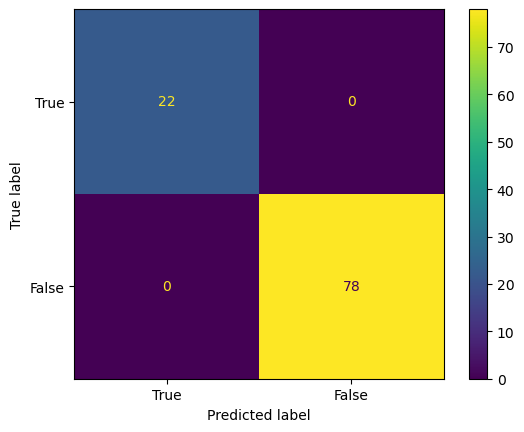

In [12]:
program_template = Program_Template(p_a, rules, T=10)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp)